# Modelling a double pendulum

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, Bidirectional

import random
from random import seed, random
from sklearn.utils import shuffle

%matplotlib inline

/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


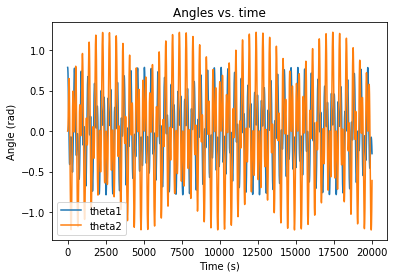

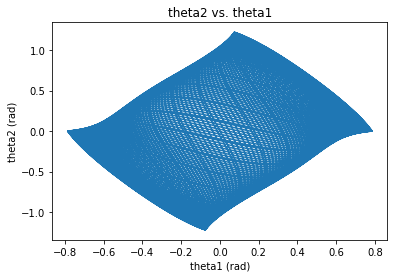

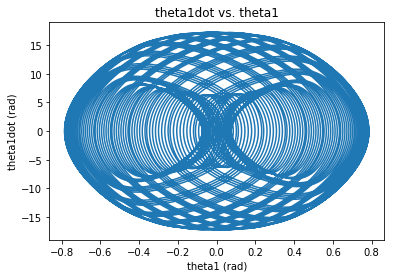

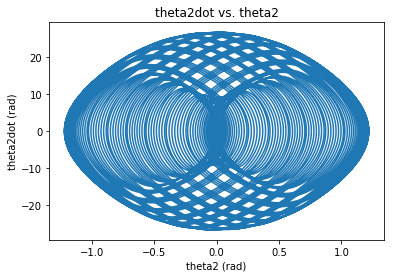

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Pendulum rod lengths (m), bob masses (kg).
L1, L2 = 0.02785, 0.0251
m1, m2 = 0.399, 0.276
# The gravitational acceleration (m.s-2).
g = 9.81

def deriv(y, t, L1, L2, m1, m2):
    """Return the first derivatives of y = theta1, z1, theta2, z2."""
    theta1, z1, theta2, z2 = y

    c, s = np.cos(theta1-theta2), np.sin(theta1-theta2)

    theta1dot = z1
    z1dot = (m2*g*np.sin(theta2) - m2*s*(L1*z1**2*c + L2*z2**2) -
             (m1+m2)*g*np.sin(theta1)) / L1 / (m1 + m2*s**2)
    theta2dot = z2
    z2dot = ((m1+m2)*(L1*z1**2*s - g*np.sin(theta2) + g*np.sin(theta1)*c) + 
             m2*L2*z2**2*s*c) / L2 / (m1 + m2*s**2)
    return theta1dot, z1dot, theta2dot, z2dot

# Maximum time, time point spacings and the time grid (all in s).
tmax, dt = 20, 0.001
t = np.arange(0, tmax+dt, dt)
# Initial conditions.
div1 = 4
div2 = 2
y0 = [np.pi/div1, 0, 0, 0]

# Do the numerical integration of the equations of motion
y = odeint(deriv, y0, t, args=(L1, L2, m1, m2))
# Unpack z and theta as a function of time
theta1, theta1dot, theta2, theta2dot  = y[:,0], y[:,1], y[:,2], y[:,3]

# Convert to Cartesian coordinates of the two bob positions.
x1 = L1 * np.sin(theta1)
y1 = -L1 * np.cos(theta1)
x2 = x1 + L2 * np.sin(theta2)
y2 = y1 - L2 * np.cos(theta2)

plt.figure()
plt.plot(theta1, label='theta1')
plt.plot(theta2, label='theta2')
plt.title('Angles vs. time')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()

plt.figure()
plt.plot(theta1, theta2)
plt.title('theta2 vs. theta1')
plt.xlabel('theta1 (rad)')
plt.ylabel('theta2 (rad)')

plt.figure()
plt.plot(theta1, theta1dot)
plt.title('theta1dot vs. theta1')
plt.xlabel('theta1 (rad)')
plt.ylabel('theta1dot (rad)')

plt.figure()
plt.plot(theta2, theta2dot)
plt.title('theta2dot vs. theta2')
plt.xlabel('theta2 (rad)')
plt.ylabel('theta2dot (rad)')

theta_pair = [[x[0], x[1]] for x in zip(theta1, theta2)]
data = np.array(theta_pair)

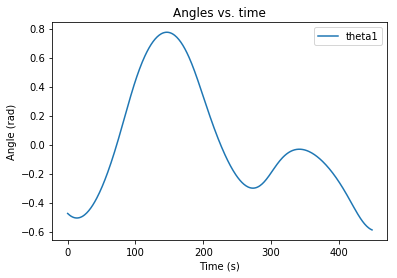

In [3]:
plt.figure()
plt.plot(theta1[300:750], label='theta1')
# plt.plot(theta2, label='theta2')
plt.title('Angles vs. time')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()

In [4]:
# hyperparameters
DATA_DIM = 2
N_PREV = 450 # number of previous steps used to predict the next step, seems to work best if includes roughly 1 cycle/period

In [5]:
def _load_data(data, n_prev=N_PREV, is_shuffled=False):
    """
    data should be pd.DataFrame()
    """
    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data[i:i+n_prev])
        docY.append(data[i+n_prev])
    alsX = np.array(docX)
    alsY = np.array(docY)
    if is_shuffled: 
        alsX, alsY = shuffle(alsX, alsY)

    return alsX, alsY

def train_test_split(df, test_size=0.2):  
    """
    This just splits data to training and testing parts
    """
    ntrn = int(round(len(df) * (1 - test_size)))

    X_train, y_train = _load_data(df[0:ntrn], is_shuffled=True)
    X_test, y_test = _load_data(df[ntrn:])

    return (X_train, y_train), (X_test, y_test)

# retrieve data
(X_train, y_train), (X_test, y_test) = train_test_split(data, 0.5)

In [14]:
# define model structure
model = Sequential()
model.add(Bidirectional(CuDNNLSTM(units=100, return_sequences=True), input_shape=(None, DATA_DIM)))
model.add(Bidirectional(CuDNNLSTM(units=50, return_sequences=False)))
# model.add(Bidirectional(LSTM(units=100, return_sequences=False)))
# model.add(Dense(units=10, activation="selu"))
model.add(Dense(units=2, activation="linear"))
model.compile(loss="mean_squared_error", optimizer="adam")

In [15]:
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.1)

Train on 15795 samples, validate on 1756 samples
Epoch 1/10
15795/15795 [==============================] - 108s 7ms/step - loss: 0.0024 - val_loss: 7.7952e-05
Epoch 2/10
15795/15795 [==============================] - 107s 7ms/step - loss: 7.1246e-05 - val_loss: 1.1376e-04
Epoch 3/10
15795/15795 [==============================] - 107s 7ms/step - loss: 5.7106e-05 - val_loss: 2.3602e-05
Epoch 4/10
15795/15795 [==============================] - 108s 7ms/step - loss: 3.5482e-05 - val_loss: 4.1960e-05
Epoch 5/10
15795/15795 [==============================] - 108s 7ms/step - loss: 3.6069e-05 - val_loss: 1.3201e-04
Epoch 6/10
15795/15795 [==============================] - 108s 7ms/step - loss: 4.0997e-05 - val_loss: 2.3994e-05
Epoch 7/10
15795/15795 [==============================] - 108s 7ms/step - loss: 2.3772e-05 - val_loss: 4.7660e-05
Epoch 8/10
15795/15795 [==============================] - 108s 7ms/step - loss: 2.6081e-05 - val_loss: 8.5420e-06
Epoch 9/10
15795/15795 [===================

In [16]:
# evaluate model fit
test_prediction = model.predict(X_test)
# score = model.evaluate(X_test, y_test)
# evaluate
print('Test score:', np.mean((test_prediction-y_test)**2))
# t_test = np.arange(0, len(y_test)*dt, dt)

Test score: 7.208723664289312e-05


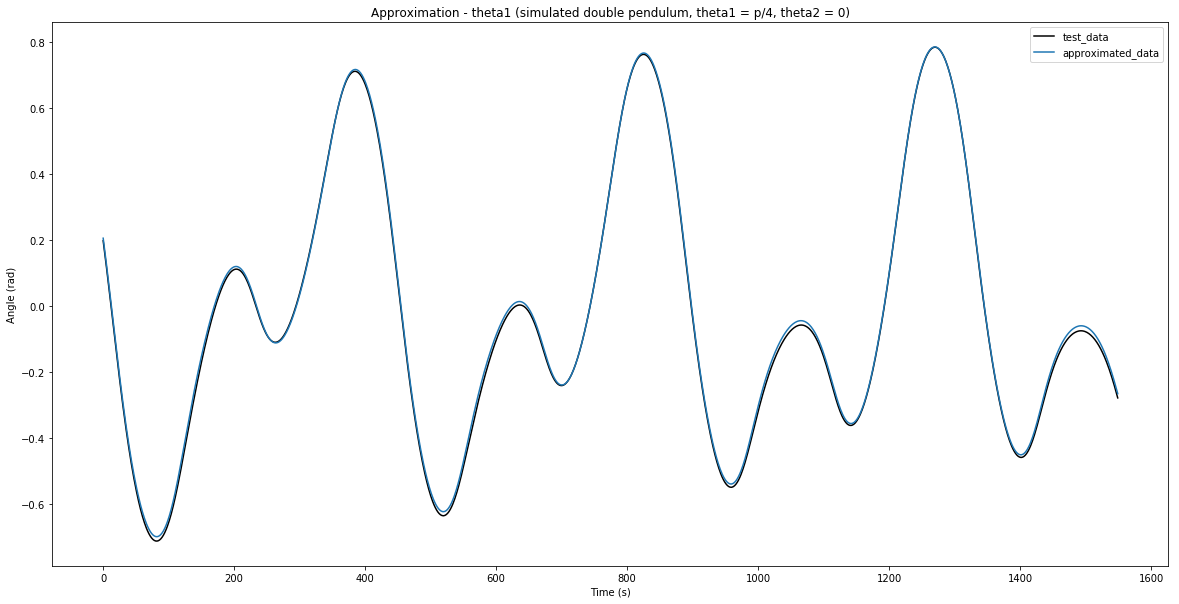

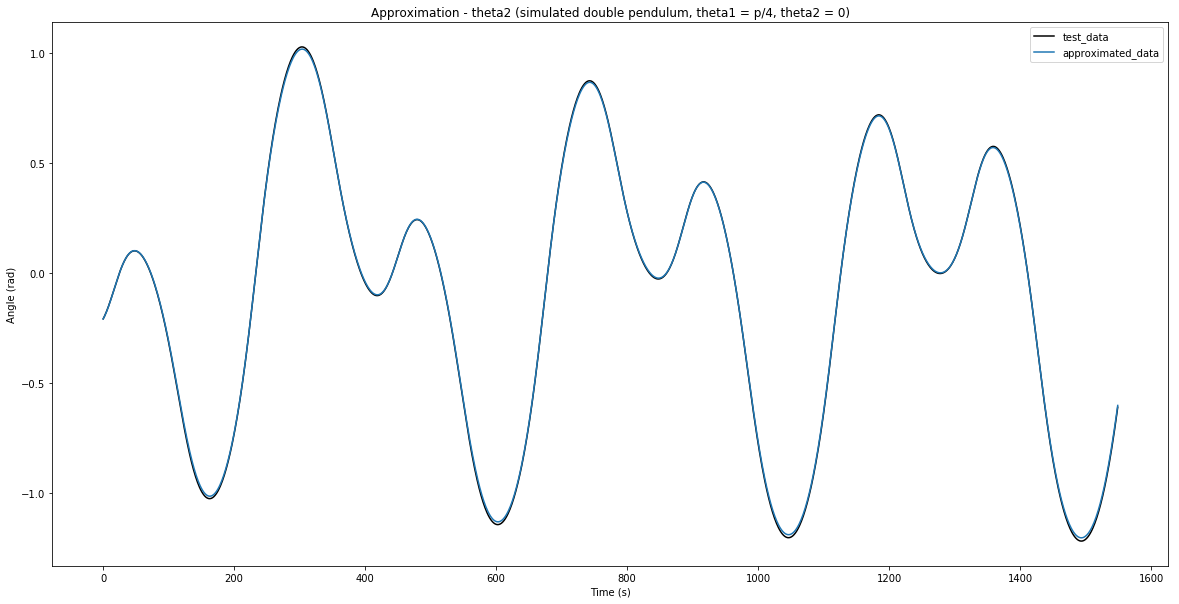

In [17]:
plt.figure(figsize=(20,10))
plt.plot(y_test[:,0], label='test_data', color='k')
plt.plot(test_prediction[:,0], label='approximated_data')
plt.title('Approximation - theta1 (simulated double pendulum, theta1 = p/4, theta2 = 0)')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()

plt.figure(figsize=(20,10))
plt.plot(y_test[:,1], label='test_data', color='k')
plt.plot(test_prediction[:,1], label='approximated_data')
plt.title('Approximation - theta2 (simulated double pendulum, theta1 = p/4, theta2 = 0)')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()

In [18]:
# perform modelling
test_data = data

X_model = X_test[0] if np.array_equal(test_data, y_test) else data[0:N_PREV]
modelled_data = []
dims = 1, X_model.shape[0], DATA_DIM

prediction_steps = len(test_data) - (0 if np.array_equal(test_data, y_test) else N_PREV)

for i in range(prediction_steps * 1):
    prev_steps = X_model.reshape(*dims)
    next_step = model.predict(prev_steps)
    modelled_data.append(list(next_step[0]))
    X_model = np.append(X_model[1:], next_step, axis=0)
    
# evaluate
modelled_data = np.array(modelled_data) if np.array_equal(test_data, y_test) else np.append(data[0:N_PREV], modelled_data, axis=0)
print('Prediction score:', np.mean((modelled_data[:len(test_data)]-test_data)**2))

Prediction score: 0.4145860035240141


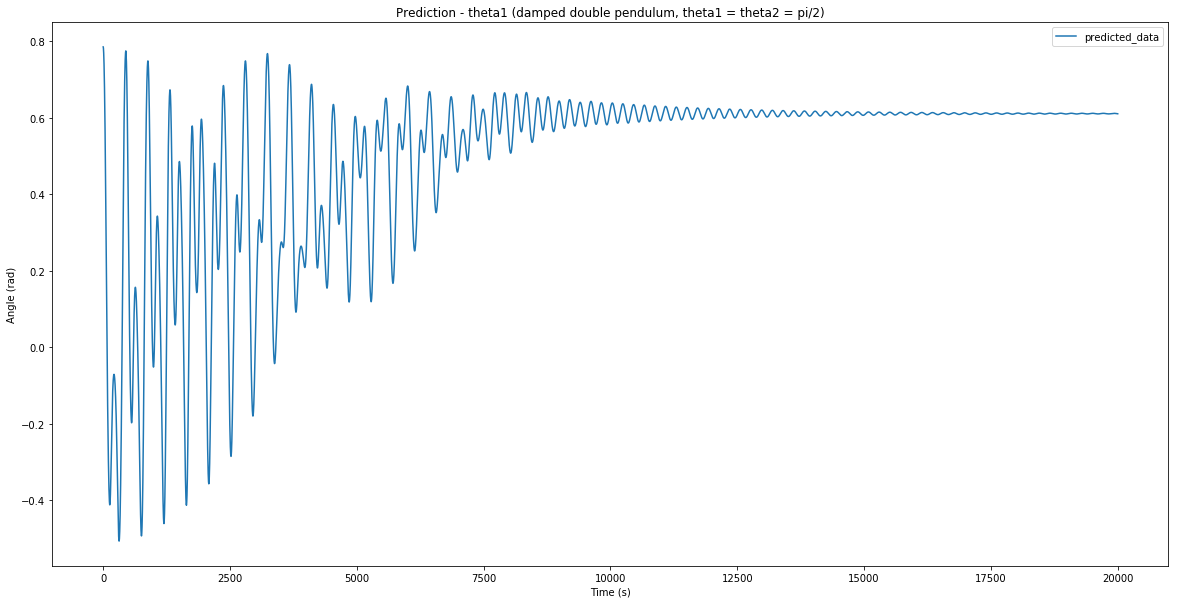

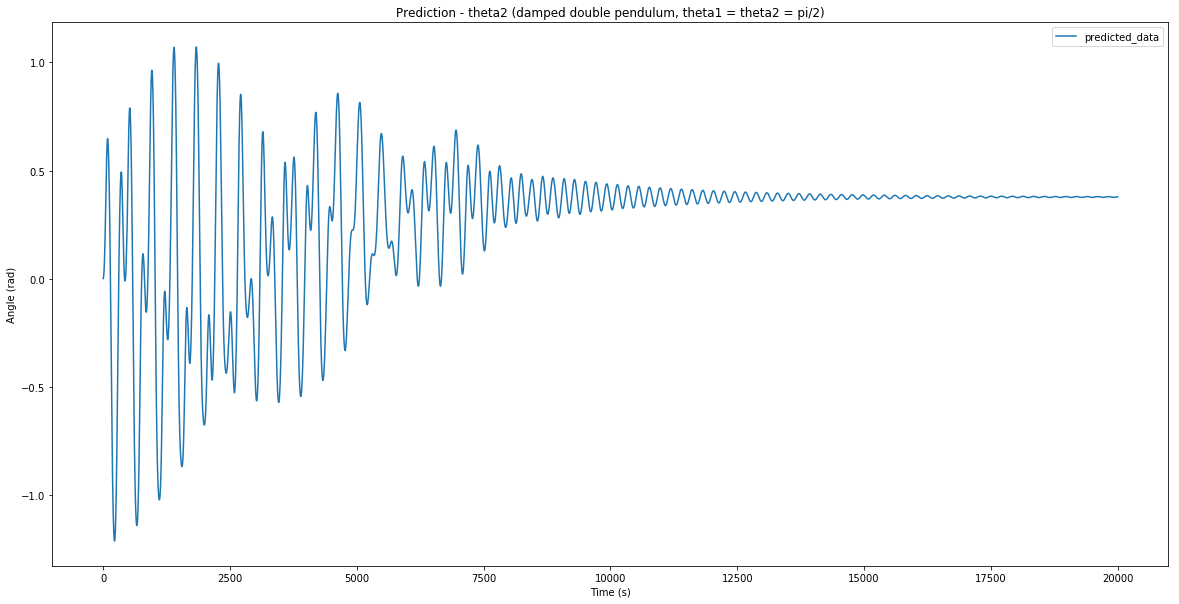

In [19]:
# visualize prediction performance
# t_start = time[-len(test_data)] if np.array_equal(test_data, y_test) else time[a]
# t2 = np.arange(t_start, t_start+len(modelled_data)*t_step, t_step)
# t2 = t2[:len(modelled_data)]

plt.figure(figsize=(20,10))
# if np.array_equal(test_data, y_test):
#     plt.plot(y_test[:,0], label='test_data', color='k')
# else:
#     plt.plot(data[:,0], label='train_data', color='k')
plt.plot(modelled_data[:,0], label='predicted_data')
plt.title('Prediction - theta1 (damped double pendulum, theta1 = theta2 = pi/2)')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()

plt.figure(figsize=(20,10))
# if np.array_equal(test_data, y_test):
#     plt.plot(y_test[:,1], label='test_data', color='k')
# else:
#     plt.plot(data[:,1], label='train_data', color='k')
plt.plot(modelled_data[:,1], label='predicted_data')
plt.title('Prediction - theta2 (damped double pendulum, theta1 = theta2 = pi/2)')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()

In [12]:
train_prediction = model.predict(X_train)

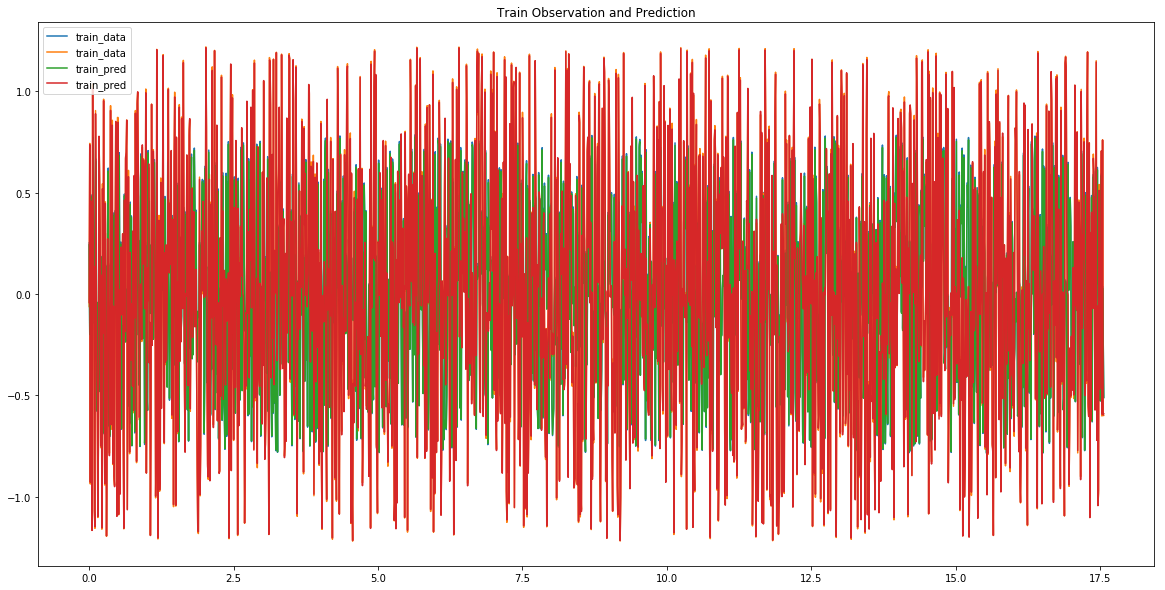

In [22]:
t_train = np.arange(0, len(y_train)*dt, dt)
plt.figure(figsize=(20,10))
plt.plot(t_train, y_train[:], label='train_data')
plt.plot(t_train, train_prediction[:], label='train_pred')
plt.title('Train Observation and Prediction')
plt.legend()